In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timewarp_lib.vector_timewarpers as vtw
import torch
import torch.nn as nn

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-qsi2gzs9 because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/home/tsr42/anaconda3/envs/timewarpvae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
fulldat = np.load("../data/trainTest2DLetterACache.npz")
print(fulldat["train"].shape)
dat = fulldat["train"]
numdims = dat.shape[2]
numts = dat.shape[1]
numtrajs = dat.shape[0]

(3750, 200, 2)


# Introduction
A DMP is a combination of a simple attractor-to-goal model and a forcing term.

The forcing term is a function of phase `x` which (without external disturbances) is a direct function of time `t`.
DMP models from the original Ijspeert paper
(and the Learning Parametric Dynamic Movement... paper)
have the forcing term affect velocity, not acceleration.

The forcing term is a linear combination of kernel functions.
The linear combination values is computed using locally weighted regression on 
the difference between the velocities that would exist at phase `x`
if we just had the attractor-to-goal and no forcing term and no external velocities
and the trajectory's actual velocity at phase `x`.
Note that this does not find the minimum squared positional error optimal weights.
Both because it is fitting velocities, not positions,
and because it is using a local fitting procedure, not finding the optimal combination
to reduce error across the whole trajectory.

# Phase vs Time

We don't use any of the flexibility that this additional complication allows,
but for consistency with Ijspeert 2002,
instead of functions of `t` for kernel functions, we use kernel functions that are 
a function of `x` according to the equations below.
This additional complication is only useful if 1) you have external perturbations during motion
and 2) you add some type of delaying/forcing function to how the phase evolves over time.
$$ \tau \dot v = \alpha_v (\beta_v (g-x) - v) $$
$$ \tau \dot x = v $$
Since we don't use any of the additional flexibility that this equation allows, this is exactly the same as saying that
$$ x = a e^{-\phi_1 t} + b e^{-\phi_2 t} $$
Where the $\phi$s are $\frac 1 {2\tau} (-\alpha_v \pm \sqrt{\alpha_v^2 - 4 \alpha_v \beta_v})$
but since $\alpha_v$ and $\beta_v$ are chosen arbitrarily, we can instead just arbitrarily set 
$x = e^{-\phi t}$ with $\phi = \log(100)$, making  $x_0 = 1$ and $\dot x_0 = -\phi$


In [3]:
tau = 1
def phase_func(t):
    phasefactor = np.log(100)
    return np.exp(-t * phasefactor)
# ts is the (scaled) timestamp
ts = np.linspace(0,1,numts)
# xs is the associated ``phase''
xs = phase_func(ts)

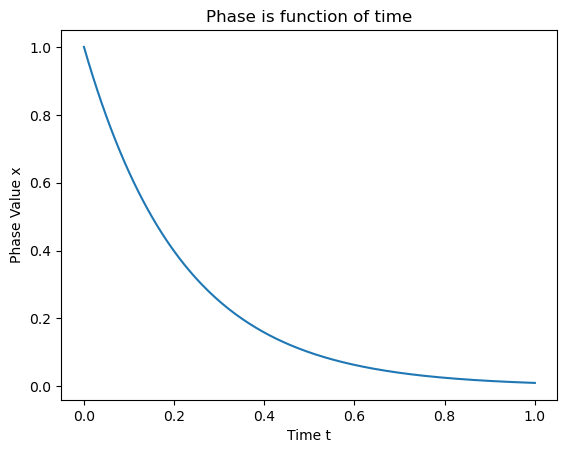

In [4]:
plt.plot(ts,xs)
plt.xlabel("Time t")
plt.ylabel("Phase Value x")
plt.title("Phase is function of time");

In [5]:
N = numts

# Estimating forcing function from data

Ijspeert 2002 explains:
For learning from a given sample trajectory,
characterized by a trajectory y demo (t), $\dot y$ demo (t) and duration T , a supervised learning problem can be formulated with the target trajectory f target = τ $\dot y$ demo − z demo
for Eq.1 (right), where z demo is obtained by integrating Eq.1 (left) with y demo instead of y.

The equations (Eq. 1) of Ijspeert 2002 are:
$$ \tau \dot z = \alpha_z (\beta_z(g-y)-z) $$
$$ \tau \dot y = z + f $$

And the integration to solve for $z(t)$ is (using $s$ instead of $t$ for evaluation to avoid
using same symbol $t$ for $dt$ and for limit of integration):
$$ z(s) = \frac 1 \tau \int_0^s \alpha_z (\beta_z (g-y_{demo}) - z) dt $$

In this way, we're estimating the forcing function that "must have existed" during the training trajectory.

The $z(t)$ we're calculating is hard to think about, but it can be thought of as "the component of the velocity due to the goal attractor". And the total velocity of the trajectory is that value $z$ plus the forcing term $f$ (times the time scaling term $\tau$).

In [6]:
# we choose these according to the suggested values in Ijspeert 2013 (didn't see suggestions in Ijspeert 2002)
alpha_z = 25
beta_z = alpha_z/4

In [7]:
# Perform numeric integration on the training data to estimate
# the component of the velocity of the trajectory that is due to the "point-attractor"
# component of the trajectory model.
# The rest of the velocity of the trajectory will be due to the "forcing term" f
def numeric_integration(ydemos, ts, tau, g, alpha_z, beta_z):
    # We perform numeric integration using small rectangles
    # with width dt = step_size
    # and height equal the value of 1/tau \alpha_z (\beta_z (g-y_{demo}) - z)
    # evaluated at the left of the rectangle.
    step_size = 0.00001
    # start integrating at the first ts
    t = ts[0]
    # Since our y_demo is only known at certain places,
    # keep track of the index i
    # of the smallest ts that is larger than our current value of t
    # when we want to compute y_delta at some t between ts[i-1] and ts[i]
    # we do linear interpolation
    i = 1
    # keep track of our cumulative sum (which numerically estimates the integral)
    z = 0
    # keep track of the integral as it progresses.
    # append a 0 to start, to avoid the fencepost problem (otherwise we have one fewer zs than ts)
    zs = []
    zs.append(z)
    # compute the integral up to each of the t values in ts, appending the result to zs each time
    while i < len(ts):
        # keep on adding dt to t and summing the rectangle value until we hit the next value in ts
        while i < len(ts) and t < ts[i]:
            # we use linear interpolation to compute the ydemo value at the intermediate t value
            interp_frac = (t - ts[i-1])/(ts[i] - ts[i-1])
            y = (1-interp_frac) * ydemos[i-1] + interp_frac * ydemos[i]
            # compute the area of the rectangle and add it to our cumulative integration.
            # note that z appears on the left and right of this expression
            z = z + (alpha_z * (beta_z * (g - y) - z)/tau * step_size)
            t += step_size
        zs.append(z)
        i += 1
    return np.array(zs)

# As a baseline check, just fit a PCA model of FTargets (don't worry about wss)

dim 0
dim 1


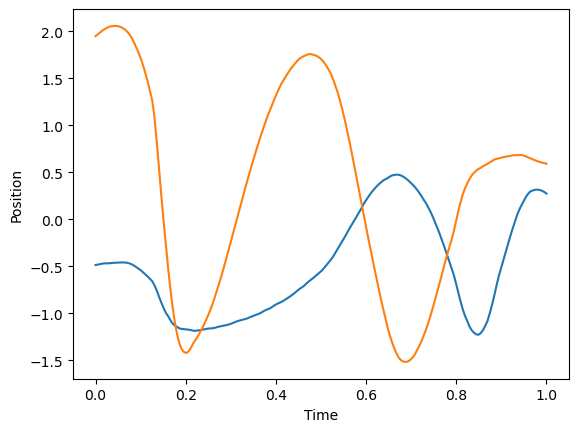

In [8]:
# zdemos is (what) the velocity of the trajectory (would be, if just the attractor model)
zdemos = []
# ftargets is the imputed forcing function
ftargets = []
# both those are arrays of arrays, with indices according to
# forcing velocity = ftargets[trajectory index][dimension]


for i in range(1):
    ftargets.append([])
    zdemos.append([])
    for dim in range(2):
        print("dim",dim)        
        ydemo = dat[i,:,dim]
        plt.plot(ts,ydemo)
        plt.xlabel("Time")
        plt.ylabel("Position")
        ydemoprime = (ydemo[2:]-ydemo[:-2])/(ts[1]-ts[0])/2
        ydemoprime = np.concatenate(((ydemo[1:2]-ydemo[:1])/(ts[1]-ts[0]),ydemoprime,(ydemo[-1:]-ydemo[-2:-1])/(ts[1]-ts[0])))

        yzero = ydemo[0]
        g = ydemo[-1]
        
        zdemo = numeric_integration(ydemo, ts, tau, g, alpha_z, beta_z)
        ftarget = tau * ydemoprime - zdemo
        ftargets[-1].append(ftarget)
        zdemos[-1].append(zdemo)

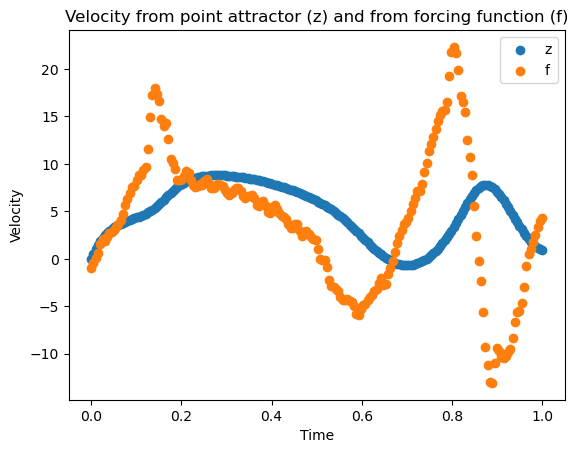

In [9]:

# indices are [trajectory_index][dimension]
plt.scatter(ts,zdemos[0][0],label="z")
plt.scatter(ts,-ftargets[0][0],label="f")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("Velocity from point attractor (z) and from forcing function (f)")
plt.legend()
plt.show()

## Reconstruct trajectory
From the weights we reconstructed the forcing function `fitted_f`.
We can then integrate and simulate forward to see what the point-attractor and forcing function together would cause the
trajectory to actually be.

In [10]:
def simulate(fitted_f, ts, g, alpha_z, beta_z, yzero):
    step_size = 0.00001
    i = 0
    t = ts[i]
    ys = [] # position
    zs = [] # velocity
    y = yzero
    z = 0
    t = 0
    while i < len(ts):
        while i < len(ts) and t < ts[i]:
            interp_frac = (t - ts[i-1])/(ts[i] - ts[i-1])
            f = (1-interp_frac) * fitted_f[i-1] + interp_frac * fitted_f[i]
            z += alpha_z * (beta_z * (g - y) - z)/tau * step_size
            y += (z + f)/tau * step_size
            t += step_size
        ys.append(y)
        zs.append(z)
        i += 1
    return (np.array(ys), np.array(zs))

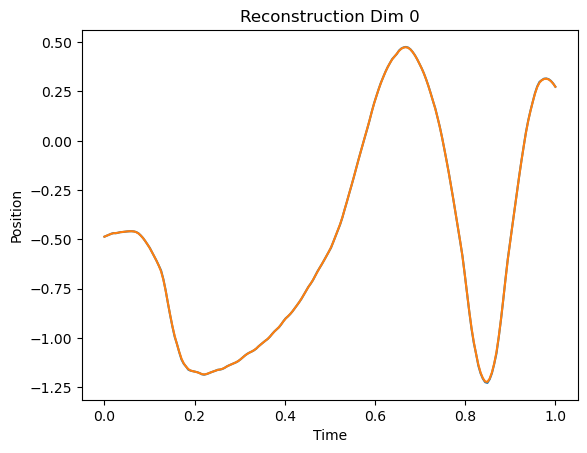

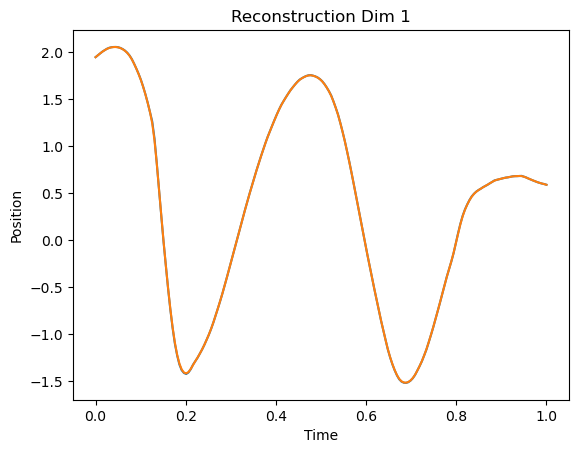

In [11]:
for dim in range(2):
    # get the trajectory dimension start and end for scaling
    ydemo = dat[0,:,dim]
    yzero = ydemo[0]
    g = ydemo[-1]
    fitted_fs = ftargets
    recon_ys,recon_zs = simulate(fitted_fs[0][dim],ts,g,alpha_z,beta_z, yzero)
    plt.plot(ts, ydemo,   label="actual")
    plt.plot(ts, recon_ys,label="recon")
    plt.xlabel("Time")
    plt.ylabel("Position")
    plt.title(f"Reconstruction Dim {dim}")
    plt.show()

## Single Function to Compute DMP parameterization of training trajectory
Write a single function to compute the DMP parameters computed in the steps above
(and confirm you get the same answer).

In [12]:
# traj should be 2d
def compute_dmp_parameterization(traj, ts, tau, alpha_z, beta_z):
    assert len(traj.shape) == 2, "traj should be 2d...just send in one trajectory"
    # reset the trajectory to start at (0,0)
    # and save the actual starting position to start_offset variables
    start_offset_0, start_offset_1 = traj[0]
    ydemos = traj-traj[0:1]
    result_dictionary = {}
    for dim in range(2):
        ydemo = ydemos[:,dim]
        ydemoprime = (ydemo[2:]-ydemo[:-2])/(ts[1]-ts[0])/2
        ydemoprime = np.concatenate(((ydemo[1:2]-ydemo[:1])/(ts[1]-ts[0]),ydemoprime,(ydemo[-1:]-ydemo[-2:-1])/(ts[1]-ts[0])))
        yzero = ydemo[0]
        assert yzero == 0 , "We shifted training trajectory to start at 0"
        g = ydemo[-1]
        zdemo = numeric_integration(ydemo, ts, tau, g, alpha_z, beta_z)
        ftarget = tau * ydemoprime - zdemo
        result_dictionary[f"ftarget_{dim}"] = ftarget
        result_dictionary[f"g_{dim}"] = g
    result_dictionary[f"start_offset_0"] = start_offset_0
    result_dictionary[f"start_offset_1"] = start_offset_1
    return result_dictionary

In [13]:
trained_model = compute_dtw_parameterization(dat[0,:,:], ts, tau, alpha_z, beta_z)

In [14]:
# check to make sure that our single-function-solution
# gets the same answer as our step-by-step approach above
for dim in range(2):
    np.testing.assert_almost_equal(trained_model[f"ftarget_{dim}"],ftargets[0][dim])
    np.testing.assert_almost_equal(trained_model[f"g_{dim}"],dat[0,-1,dim] - dat[0,0,dim])
    np.testing.assert_almost_equal(trained_model[f"start_offset_{dim}"],dat[0,0,dim])

## Single function to reconstruct trajectory from parameter vector

In [15]:
def convert_dic_to_parameter_vector(dic):
    params = np.concatenate((dic["ftarget_0"],dic["ftarget_1"],
                                    [dic["start_offset_0"],dic["start_offset_1"],
                                    dic["g_0"],dic["g_1"]]
                                   )).reshape(1,-1)
    return params

In [16]:
def decode_parameter_vector(parameter_vector, N):
    ftarget_0 = parameter_vector[:N]
    ftarget_1 = parameter_vector[N:2*N]
    start_offset_0,start_offset_1,g_0,g_1 = parameter_vector[2*N:]
    
    positions = []
    for g, ftarget, start_offset in [(g_0,ftarget_0,start_offset_0), (g_1,ftarget_1,start_offset_1)]:
        yzero=0 # centered training data all starts at zero
        fitted_f = ftarget
        # ys = position, zs = velocity
        ys,zs = simulate(fitted_f,ts,g,alpha_z,beta_z,yzero)
        positions.append(ys + start_offset)
    positions=np.array(positions).T
    return positions

In [17]:
param_vect = convert_dic_to_parameter_vector(trained_model)[0]
positions = decode_parameter_vector(param_vect, N)

In [18]:
# check to make sure that our single-function-solution
# gets the same answer as our step-by-step approach above
for dim in range(2):
    # get the trajectory dimension start and end for scaling
    ydemo = dat[0,:,dim]
    yzero = ydemo[0]
    g = ydemo[-1]
    recon_ys,recon_zs = simulate(fitted_fs[0][dim],ts,g,alpha_z,beta_z, yzero)
    np.testing.assert_almost_equal(positions[:,dim],recon_ys)

# Train a linear PCA model on the dmp parameters

In [19]:
def train_dmp_parameter_model(training_data, latent_dim, scale_last_four_dims):
    num_trajs, num_channels = training_data.shape
    print(f"we have num_trajs:{num_trajs}, num_channels:{num_channels}")
    scaled_params = np.copy(training_data)
    
    scaled_params[:,-4:] = scaled_params[:,-4:] * scale_last_four_dims
    N = int((num_channels-4)/2)
    
    

    # compute and remove the mean parameter values (mean parameter values is of shape (num_channels))
    mean_params = np.mean(scaled_params, axis=0)
    assert len(mean_params) == N*2 + 4, "mean parameter should be valid parameterization"
    centered_params = scaled_params - mean_params[np.newaxis,:]

    # compute the PCA model using SVD
    u, s, vt = np.linalg.svd(centered_params)
    

    # keep only the first latent_dim number of dimensions
    if len(s) < latent_dim:
        raise Exception(f"You can't build a model of dimension {latent_dim} on a dataset with dimensionality {len(s)}")

    # the singular values written in matrix form
    smat = np.diag(s[:latent_dim])
    smatinv = np.diag(1./s[:latent_dim])
    # the first latent_dim directions of variation
    basis_vectors = vt[:latent_dim,:]
    # given a trajectory, use this to find its value in the latent space 
    # note that the dimensions of the embedding matrix are (latent_dim, nt*nc)
    embedding_matrix = smatinv @ basis_vectors 
    # note that we include the s factor here so that our latent space is roughly the unit gaussian ball :brain:
    # note further that the dimensions of the reconstruction matrix are also (latent_dim, nt*nc)
    reconstruction_matrix = smat @ basis_vectors
    
    # store the basis_vectors too,
    # so that we can avoid numerical imprecision from smatinv * smat

    return {
      "num_trajs" : num_trajs,
      "num_channels" : num_channels,
      "latent_dim" : latent_dim,
      "mean_params" : mean_params,
      "embedding_matrix" : embedding_matrix,
      "reconstruction_matrix" : reconstruction_matrix,
      "basis_vectors" : basis_vectors}

In [20]:
# Create a ModelApplier object based purely on a
# directory containing model information
class ModelApplier(object):
    def __init__(self, modeldata):
        self.num_trajs = modeldata["num_trajs"]
        self.num_channels = modeldata["num_channels"]
        self.latent_dim = modeldata["latent_dim"]
        self.mean_params = modeldata["mean_params"]
        self.embedding_matrix = modeldata["embedding_matrix"]
        self.reconstruction_matrix = modeldata["reconstruction_matrix"]
        self.basis_vectors = modeldata["basis_vectors"]

    # The input data should be of the shape
    # (num_apply_trajs, apply_latent_dim)
    def recon(self, data):
        num_apply_trajs, apply_latent_dim = data.shape
        if apply_latent_dim != self.latent_dim:
              raise Exception(f"The number of latent dim coordinates given: {apply_latent_dim} was not the same as the {self.latent_dim} expected by the model")

        # compute the linear combination of basis vectors 
        traj_offset_vectors = data @ self.reconstruction_matrix
        mean_vector = self.mean_params.reshape(1,self.num_channels)
        # add back the mean vector
        traj_vectors = traj_offset_vectors + mean_vector
        # reshape to the official standard expected shape
        # (num_apply_trajs, num_timesteps, num_channels)
        result_trajs = traj_vectors.reshape(num_apply_trajs, self.num_channels)
        return result_trajs

    # The input data should be of the shape
    # (num_apply_trajs, self.num_channels)
    # The output latent dimensions are of the shape
    # (num_apply_trajs, self.latent_dim)
    def embed(self, data):
        num_apply_trajs, apply_num_channels = data.shape
        assert apply_num_channels == self.num_channels, "channels must match for PCA"

        flattened_trajs = data
        mean_vector = self.mean_params.reshape(1,self.num_channels)
        centered_trajs = flattened_trajs - mean_vector
        # the dimensions of the embedding matrix are (latent_dim, nc)
        latent_vals_mat = centered_trajs @ self.embedding_matrix.T
        return(latent_vals_mat)

In [21]:
scale_param = 100.

In [22]:
# trivial check that a 1D model on 2 parameters gives perfect reconstructions of that model
two_dicts = [compute_dmp_parameterization(dat[i,:,:], ts, tau, alpha_z, beta_z) for i in range(2)]
two_vectors = np.concatenate([convert_dic_to_parameter_vector(two_dicts[i]) for i in range(2)],axis=0)
       
# compute dmp parameters for two trajectories

perf_model_params = train_dmp_parameter_model(two_vectors, 1, scale_param)
perf_model = ModelApplier(perf_model_params)

np.testing.assert_almost_equal(np.sum(np.square(perf_model.basis_vectors[0])),1)

scaled_two_vectors = np.copy(two_vectors)
scaled_two_vectors[:,-4:] *= scale_param

np.testing.assert_almost_equal(perf_model.recon(perf_model.embed(scaled_two_vectors)), scaled_two_vectors)


we have num_trajs:2, num_channels:404


## Given a PCA model on training data, compute round-trip test error
Round-trip test error computed with and without DTW temporal alignment

In [23]:
test_time_dtw_vector_timewarper = vtw.DTWVectorTimewarper()

In [24]:
def round_trip_loss(ma, traj, logging_index, ts, tau, alpha_z, beta_z, scale_last_four_dims):
    assert len(traj.shape) == 2, "pass in one traj at a time"
    num_ts, channels = traj.shape
    N = num_ts
    assert channels == 2, "2 channels for handwriting"
    dic = compute_dtw_parameterization(traj, ts, tau, alpha_z, beta_z)
    params = np.concatenate((dic["ftarget_0"],dic["ftarget_1"],
                                    [dic["start_offset_0"],dic["start_offset_1"],
                                    dic["g_0"],dic["g_1"]]
                                   )).reshape(1,-1)
    params_copy = np.copy(params)
    params_copy[:,-4:] = scale_last_four_dims * params_copy[:,-4:]
    
    new_parameters = ma.recon(ma.embed(params_copy))
    recon_scaled = np.copy(new_parameters)
    new_parameters[0][-4:] = new_parameters[0][-4:]/scale_last_four_dims
    pos = decode_parameter_vector(new_parameters[0], N)
    recon_train = pos.reshape((1,num_ts, channels))
    train = traj.reshape((1,num_ts, channels))
    #plt.plot(train[0,:,0],train[0,:,1],label="train")
    #plt.plot(recon_train[0,:,0],recon_train[0,:,1],label="recon")
    #plt.show()
    #
    ##plt.plot(params[0])
    #plt.plot(params_copy[0])
    #plt.plot(recon_scaled[0])
    #plt.show()
    
    train_dtw_recon, train_dtw_actual = test_time_dtw_vector_timewarper.timewarp_first_and_second(
        torch.tensor(recon_train,dtype=torch.float), 
        torch.tensor(train,dtype=torch.float))
    train_aligned_loss = (
        nn.functional.mse_loss(train_dtw_recon, train_dtw_actual, reduction="sum").detach().numpy()
        / (num_ts))
    train_error = np.sum(np.square(recon_train - train))/(num_ts)
    
    params_error = np.sqrt(np.sum(np.square(params_copy - recon_scaled)))
    squareresults = (ma.latent_dim, train_aligned_loss, train_error, logging_index, params_error)
    return squareresults

In [25]:
# we don't have a perfect round-trip loss because
# the dmp model applied by itself still has some error.

#round-trip error for a perfect linear model that exactly reconstructs dmp parameters
trajid = 0
(_,_,train_err,_,_) = round_trip_loss(perf_model, dat[trajid],trajid, ts, tau, alpha_z, beta_z, scale_param)

# error for the dmp model
combined_squared_error = 0
for dim in range(2):
    # get the trajectory dimension start and end for scaling
    ydemo = dat[0,:,dim]
    yzero = ydemo[0]
    g = ydemo[-1]
    recon_ys,recon_zs = simulate(fitted_fs[0][dim],ts,g,alpha_z,beta_z, yzero)
    combined_squared_error += np.mean((recon_ys - ydemo)**2)
    
# they tie out
np.testing.assert_almost_equal(train_err, combined_squared_error)

In [26]:
important_results_object = []
for i in range(len(dat)):
    if i % 10 == 0:
        print(i)
    result_dictionary = compute_dmp_parameterization(dat[i], ts, tau, alpha_z, beta_z)
    important_results_object.append(result_dictionary)
    
parameters_vector = np.array([np.concatenate((dic["ftarget_0"],dic["ftarget_1"],
                                    [dic["start_offset_0"],dic["start_offset_1"],
                                    dic["g_0"],dic["g_1"]]
                                   ))
                     for dic in important_results_object])

np.save("dmpmodels/parameters_vector_dmps_simple.npy", parameters_vector)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [27]:
parameters_vector = np.load("dmpmodels/parameters_vector_dmps_simple.npy")
for latent_dim in range(1,17):
    vals = train_dmp_parameter_model(parameters_vector,latent_dim, scale_last_four_dims=scale_param)
    np.savez(f"dmpmodels/parametric_dmp_{latent_dim}_simple.npz", dic=vals)

we have num_trajs:3750, num_channels:404
we have num_trajs:3750, num_channels:404
we have num_trajs:3750, num_channels:404
we have num_trajs:3750, num_channels:404
we have num_trajs:3750, num_channels:404
we have num_trajs:3750, num_channels:404
we have num_trajs:3750, num_channels:404
we have num_trajs:3750, num_channels:404
we have num_trajs:3750, num_channels:404
we have num_trajs:3750, num_channels:404
we have num_trajs:3750, num_channels:404
we have num_trajs:3750, num_channels:404
we have num_trajs:3750, num_channels:404
we have num_trajs:3750, num_channels:404
we have num_trajs:3750, num_channels:404
we have num_trajs:3750, num_channels:404


In [29]:
DATAFILE=f"../data/trainTest2DLetterARescaled.npz"
data = np.load(DATAFILE)
test = data["test"]
train = data["train"]
num_trains, num_ts, channels = train.shape
num_tests, num_ts, channels = test.shape

for latent_dim in range(1,17):
    print(latent_dim)
    vals = np.load(f"dmpmodels/parametric_dmp_{latent_dim}_simple.npz",allow_pickle=True)["dic"].item()
    ma = ModelApplier(vals)
    all_results = []
    for dataset in [train, test]:
        print("running a dataset")
        square_losses = []
        for i in range(len(dataset)):
            if i % 10 == 0:
                print(i)
            square_losses.append(round_trip_loss(ma, dataset[i],trajid, ts, tau, alpha_z, beta_z,
                                                 scale_param))
        square_losses = np.array(square_losses)
        all_results.append(square_losses)
    np.savez(f"dmpmodels/intermediate_dmp_error_results_{latent_dim}_simple.npz",train=all_results[0], test=all_results[1])

1
running a dataset
0
10
20
30
40
50
60
70
80
90
100
110
120
running a dataset
0
10
20
30
40
50
60
70
80
90
100
110
120
2
running a dataset
0
10
20
30
40
50
60
70
80
90
100
110
120
running a dataset
0
10
20
30
40
50
60
70
80
90
100
110
120
3
running a dataset
0
10
20
30
40
50
60
70
80
90
100
110
120
running a dataset
0
10
20
30
40
50
60
70
80
90
100
110
120
4
running a dataset
0
10
20
30
40
50
60
70
80
90
100
110
120
running a dataset
0
10
20
30
40
50
60
70
80
90
100
110
120
5
running a dataset
0
10
20
30
40
50
60
70
80
90
100
110
120
running a dataset
0
10
20
30
40
50
60
70
80
90
100
110
120
6
running a dataset
0
10
20
30
40
50
60
70
80
90
100
110
120
running a dataset
0
10
20
30
40
50
60
70
80
90
100
110
120
7
running a dataset
0
10
20
30
40
50
60
70
80
90
100
110
120
running a dataset
0
10
20
30
40
50
60
70
80
90
100
110
120
8
running a dataset
0
10
20
30
40
50
60
70
80
90
100
110
120
running a dataset
0
10
20
30
40
50
60
70
80
90
100
110
120
9
running a dataset
0
10
20
30
40
50
60


In [39]:
final_results = []
for latent_dim in range(1,17):
    intermediate_results = np.load(f"dmpmodels/intermediate_dmp_error_results_{latent_dim}_simple.npz")
    valid_inds = intermediate_results["train"][:,0] == latent_dim
    #if np.sum(valid_inds) != 125:
    #    continue
    ld,train_aligned_loss, train_error, checkval, paramerror = np.mean(intermediate_results["train"][valid_inds,],axis=0)
    assert ld == latent_dim, "check your latent_dim"
    #assert checkval == 62, "should have indices ranging from 0 to 124"
    
    valid_inds = intermediate_results["test"][:,0] == latent_dim
    latent_dim,test_aligned_loss, test_error, checkval, paramerror = np.mean(intermediate_results["test"][valid_inds,],axis=0)
    assert ld == latent_dim, "check your latent_dim"
    #assert checkval == 62, "should have indices ranging from 0 to 124"
    
    final_results.append((latent_dim, np.sqrt(train_aligned_loss),
                          np.sqrt(test_aligned_loss), 
                       np.sqrt(train_error), 
                          np.sqrt(test_error)
                         ))
final_results = np.array(final_results)
np.save("dmpmodels/dmp_results_simple",final_results)

In [40]:
final_results

array([[ 1.        ,  0.67860103,  0.66613074,  0.92280638,  0.92664313],
       [ 2.        ,  0.63807743,  0.62368892,  0.83348037,  0.82446318],
       [ 3.        ,  0.60715319,  0.60487168,  0.78222608,  0.78570117],
       [ 4.        ,  0.56911967,  0.57712289,  0.74087928,  0.75141257],
       [ 5.        ,  0.43192342,  0.42694624,  0.60283102,  0.59613211],
       [ 6.        ,  0.40821406,  0.41280948,  0.56238612,  0.56586862],
       [ 7.        ,  0.3904214 ,  0.39956524,  0.52944707,  0.53485682],
       [ 8.        ,  0.37721482,  0.38967196,  0.50013865,  0.51203511],
       [ 9.        ,  0.30605797,  0.30391475,  0.42789217,  0.43109513],
       [10.        ,  0.28227167,  0.28781444,  0.40142251,  0.40941302],
       [11.        ,  0.26764103,  0.27545993,  0.37393668,  0.38616809],
       [12.        ,  0.25333944,  0.26559837,  0.35250012,  0.36789292],
       [13.        ,  0.24837707,  0.26251429,  0.34083044,  0.35847263],
       [14.        ,  0.24402864,  0.2

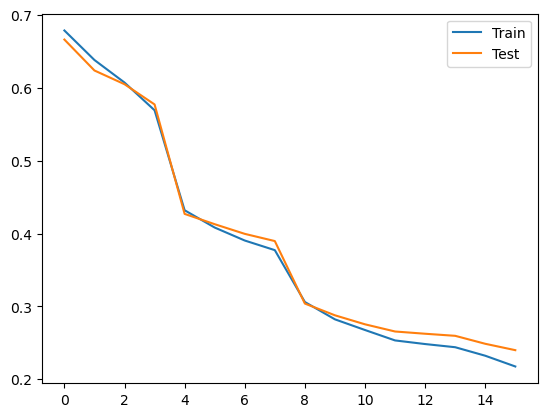

In [36]:
plt.plot(final_results[:,1],label="Train")
plt.plot(final_results[:,2], label="Test")
plt.legend()

## 